In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from tqdm import tqdm

Read clock image, find its bounding circle and center the image

In [32]:
image_path = "img/clock.jpg"

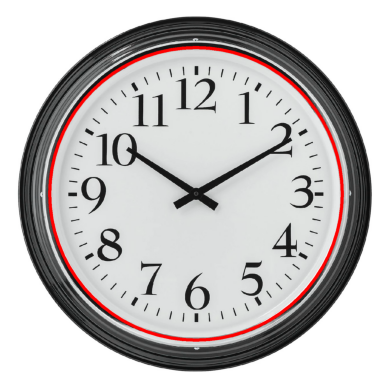

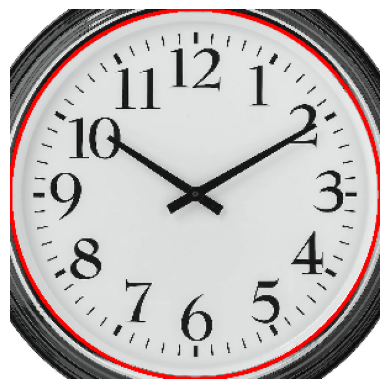

In [33]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, (11, 11), 0)

circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=600, param1=100, param2=100, minRadius=200, maxRadius=600)

if circles is not None:
    # circle coordinates to integers
    circles = np.uint16(np.around(circles))
    circle = circles[0, :][0]

    center = (circle[0], circle[1])
    radius = circle[2]

    cv2.circle(image, center, radius, (255, 0, 0), 10)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    x, y = center
    size = radius * 2

    # square bounding box
    left = x - radius
    right = x + radius
    top = y - radius
    bottom = y + radius

    # extend the shorter dimension
    width = right - left
    height = bottom - top

    if width > height:
        diff = width - height
        top = max(0, top - diff // 2)
        bottom = min(image.shape[0], bottom + diff // 2)
    elif height > width:
        diff = height - width
        left = max(0, left - diff // 2)
        right = min(image.shape[1], right + diff // 2)

    cropped_image = image[top:bottom, left:right]

    cropped_image_resized = cv2.resize(cropped_image, (300, 300))

    plt.imshow(cropped_image_resized, cmap="gray")
    plt.axis('off')


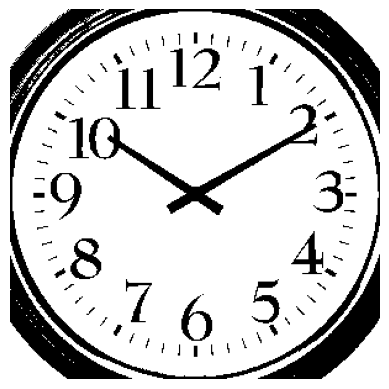

In [34]:
clock = cv2.cvtColor(cropped_image_resized, cv2.COLOR_BGR2GRAY)
_, clock = cv2.threshold(clock, 127, 255, cv2.THRESH_BINARY)
plt.axis("off")
plt.imshow(clock, cmap="gray")

In [35]:
def generate_clock(h: int, m: int) -> np.ndarray:
    """
    Generates a clockface for a given hour and minute.
    """
    h_r = 0.4
    m_r = 0.6

    h_ang = (np.pi / 2 + (-h / 12) * 2 * np.pi - ((2 * np.pi) / 12) * (m/60))
    m_ang = (np.pi / 2 + (-m / 60) * 2 * np.pi)

    h_x = h_r * np.cos(h_ang)
    h_y = h_r * np.sin(h_ang)

    m_x = m_r * np.cos(m_ang)
    m_y = m_r * np.sin(m_ang)

    plt.clf()

    plt.plot([0, h_x], [0, h_y], "black", linewidth=3)
    plt.plot([0, m_x], [0, m_y], "black", linewidth=3)

    plt.axis("square")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis("off")

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', pad_inches=0)
    plt.close()

    def buf2img(buf: BytesIO) -> np.ndarray:
        buf.seek(0)
        img = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
        return img
    
    img = buf2img(buf)
    return img

Generate all possible clockfaces

In [15]:
generated_clocks = []
with tqdm(total=12*60) as pbar:
    for h in range(0, 12):
        for m in range(0, 60):
            generated_clock = generate_clock(h, m)
            generated_clocks.append(generated_clock)

            pbar.update(1)
            

100%|██████████| 720/720 [00:14<00:00, 50.55it/s]


See which generated clockface has the most overlap with the actual clock

720it [00:00, 11775.28it/s]

best guess at generated clock #610 - 10:10


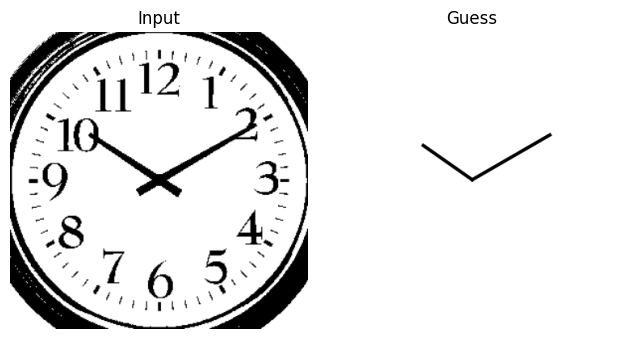

In [36]:
# idx err
best_guess = (None, 0)

guess_perf_history = []

generated_clock = generate_clock(0, 0)

width, height = generated_clock.shape

clock = cv2.resize(clock, (width, height))

for index, generated_clock in tqdm(enumerate(generated_clocks)):
    # get guess where most black pixels overlap
    overlap = cv2.bitwise_and(clock, generated_clock)
    ones = np.count_nonzero(overlap)

    guess_perf_history.append(ones)

    if ones > best_guess[1]:
        best_guess = (index, ones)

best_index = best_guess[0]
h = best_index // 60
m = best_index % 60
print(f"best guess at generated clock #{best_index} - {h}:{m}")

fig, axes = plt.subplots(1, 2)

axes[0].imshow(clock, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Input")

axes[1].imshow(generated_clocks[best_index], cmap='gray')
axes[1].axis('off')
axes[1].set_title("Guess")

plt.tight_layout()

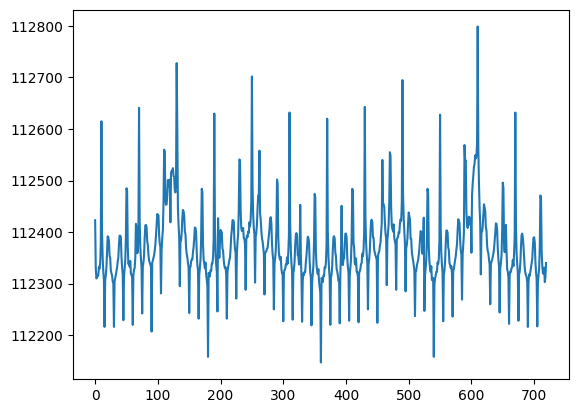

In [37]:
plt.plot(guess_perf_history)